In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys

from u8timeseries.models.prophet import Prophet
from u8timeseries.models.baselines import KthValueAgoBaseline
from u8timeseries.models.exponential_smoothing import ExponentialSmoothing
from u8timeseries.models.arima import Arima, AutoArima
from u8timeseries.models.standard_regressive_model import StandardRegressiveModel
from u8timeseries.models.theta import Theta


from u8timeseries.timeseries import TimeSeries
from u8timeseries.metrics.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting.forecasting_simulation import simulate_forecast_ar, simulate_forecast_regr
from u8timeseries.backtesting.backtesting_udf import get_train_val_series, backtest_autoregressive_model
from u8timeseries.models.statistics import check_seasonality, plot_acf

import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

## Read data

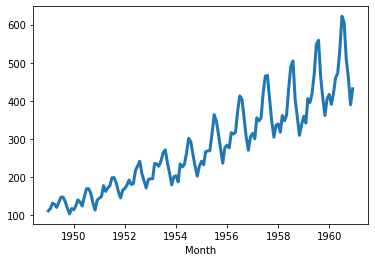

In [2]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.plot(lw=3)

## Exploration

Before building any kind of model, it is good to understand the characteristics of our TimeSeries.

For example, the Air Passenger data seems to have a seasonal trend, with a yearly period. 
The existence of such a trend can be explored using the auto-correlation function (ACF).

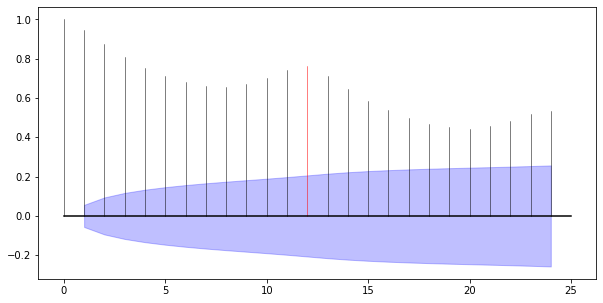

In [3]:
plot_acf(series, m = 12, alpha = .05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of alpha = 5%.

Even working with this very well-known case, one can see that the x = 11 value of the ACF is quite close to being a local maximum. Thus is it is useful to have a statistical check of seasonality against a particular value of the period m.

In [4]:
for i in range(2, 13):
    season, period = check_seasonality(series, m = i, alpha = .05)
    
    if season:
        print('There is seasonality of order {}.'.format(period))
    else:
        print('There is no seasonality of order {}.'.format(period))

There is no seasonality of order 2.
There is no seasonality of order 3.
There is no seasonality of order 4.
There is no seasonality of order 5.
There is no seasonality of order 6.
There is no seasonality of order 7.
There is no seasonality of order 8.
There is no seasonality of order 9.
There is no seasonality of order 10.
There is no seasonality of order 11.
There is seasonality of order 12.


A stastical check confirms our intuition!

## Build three models

In [5]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
model_ar = Arima(2, 1, 5)
model_bl = KthValueAgoBaseline(k=12)

## Try one of the models
Here we'll just do a one shot prediction. Prediction time will be 1957-01-01, and we'll forecast the rest of the time series from that point on.

Definition: *prediction time* is the time *at which* a forecast is made, and *forecast time* is the time *for which* the forecast is made.

For instance, in the example below, prediction time is 1957-01-01, and forecast time is the time range between 1957-02-01 and the end of the time series.

The error will be measured using the MAPE error function.

In [6]:
train, val = series.split_after(pd.Timestamp('19570101'))
model_es.fit(train)
pred = model_es.predict(len(val))

print('The MAPE is: {:.3f}'.format(mape(pred, val)))

The MAPE is: 4.760


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



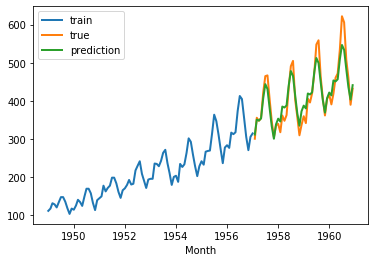

In [7]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## The Theta method

The module theta.py contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has known great success, particularly in the M3-competition.

Though the value of the Theta parameter is mainly set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. As an example, we will apply this process to our Air Passenger data.

In [8]:
# theta = 0 is the default parameter.
model_theta_0 = Theta()

# We know that there is a yearly seasonality, so we include the parameter season_period.
model_theta_0.fit(train, season_period = 12)
pred_theta_0 = model_theta_0.predict(len(val))

print('The MAPE is: {:.3f}'.format(mape(pred_theta_0, val)))

The MAPE is: 11.265


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



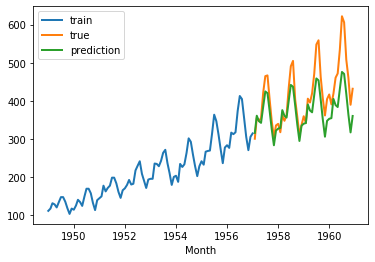

In [9]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred_theta_0.plot(lw=2, label='prediction')
plt.legend()

Clearly this prediction not as good as the exponential smoothing above. But what about different values of theta?

In [10]:
# Search for the best theta parameter.
thetas = np.linspace(-10, 10, 200)


# The best configuration is, for now, the only one we know: with theta = 0, computed above.
best_mape = 11
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train, 12)
    pred_theta = model.predict(len(val))
    res = mape(pred_theta, val)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



In [11]:
model = Theta(best_theta)
model.fit(train, 12)
pred_best_theta = model.predict(len(val))

print('The MAPE is: {:.3f}, with theta = {}.'.format(mape(pred_best_theta, val), best_theta))

The MAPE is: 4.407, with theta = 5.577889447236181.


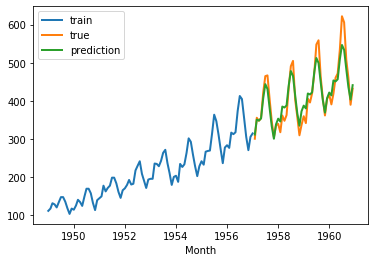

In [12]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()
plt.show()

We can observe that the model with `best_theta` is so far the best we have, in terms of MAPE.

## Simulate historical forecasting
Here we'll do some backtesting. We will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 6 months in the future (compared to prediction time).

In [13]:
historical_fcast = simulate_forecast_ar(series, model_es, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

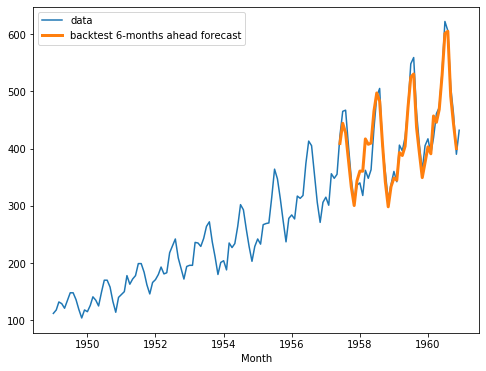

In [14]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [15]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [16]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



Backtest done in 68.15 s.


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



Backtest done in 181.07 s.
Backtest done in 0.38 s.


### Plot the user-defined backtesting results

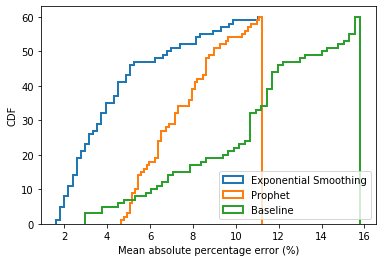

In [17]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

### Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



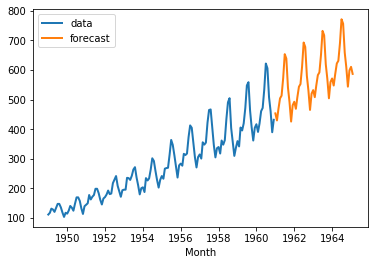

In [18]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.plot(label='data', lw=2)
pred.plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [19]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                       for m in models]

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [20]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

.............................

MAPE Error Exponential smoothing: 3.0968566217117512
MAPE Error Prophet: 7.3489517330137035
MAPE Error ensemble: 5.860589208417881


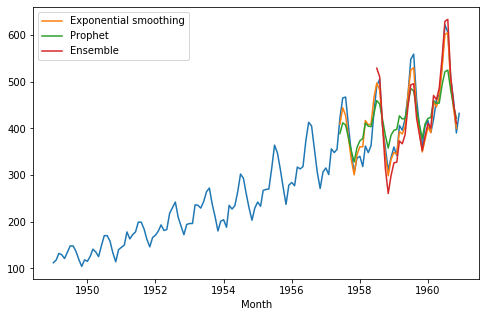

In [21]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

## Example of forecasting using a regressive model and extra features